In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install ttach
!pip3 install --upgrade albumentations

     |████████████████████████████████| 81kB 6.8MB/s 
     |████████████████████████████████| 952kB 13.2MB/s 
     |████████████████████████████████| 37.6MB 79kB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import os
from pathlib import Path

import torchvision
from torchvision import datasets

import numpy as np
import pandas as pd
from PIL import Image
import cv2
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import ttach as tta

import albumentations as A
import albumentations.pytorch

In [4]:
print(f'albumentations should be at least 0.5.2. Installed: {albumentations.__version__}')

albumentations should be at least 0.5.2. Installed: 0.5.2


In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Projects/cv/cat dogs classifier/src')

In [6]:
import models
import config

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
start = time.time()

In [8]:
# setting seed
torch.manual_seed(0)
np.random.seed(0)

In [9]:
# setting device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
# HYPERPARAMS HERE

# params
lr = 0.01
momentum = 0.9 # was 0.9
weight_decay = 3e-3

# lr scheduler
step_size = 4 # after this many epochs we will mult our lr by gamma
gamma = 0.1 # lr multiplier every step_size epochs

# transforms
presize = 224
crop = 224

# batch size
batch_size = 64

# n_epochs
frozen = 3
unfrozen = 25

# tta
tta_crop = int(presize*0.9)

In [11]:
# transforms
train_transform = A.Compose([
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.RandomCropNearBBox(),
        # A.SmallestMaxSize(presize),
        # A.LongestMaxSize(presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        A.Normalize(),
        A.Rotate(limit=20),
        A.HorizontalFlip(),
        # A.Cutout(),
        albumentations.pytorch.ToTensorV2()], 
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

valid_transform = A.Compose([
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.LongestMaxSize(presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        # A.SmallestMaxSize(presize),
        # A.CenterCrop(crop, crop),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()],
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

test_transform = A.Compose([
        A.RandomSizedBBoxSafeCrop(presize, presize),
        # A.LongestMaxSize(presize),
        # A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
        # A.SmallestMaxSize(presize),
        # A.CenterCrop(crop, crop),
        A.Normalize(),
        albumentations.pytorch.ToTensorV2()],
        bbox_params=A.BboxParams(format='albumentations', min_area=256, min_visibility=0.1))

In [12]:
# dataset class
class dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return (self.df.shape[0])

    def __getitem__(self, index):
        # image = cv2.imread(self.df.fname[index])
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = plt.imread(self.df.fname[index])
        image = Image.open(self.df.fname[index]).convert('RGB')
        image = np.array(image)

        class_id = self.df.label[index]

        xmin = self.df.xmin_alb[index]
        ymin = self.df.ymin_alb[index]
        xmax = self.df.xmax_alb[index]
        ymax = self.df.ymax_alb[index]

        bboxes = [[xmin, ymin, xmax, ymax, class_id]]

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes)
            
            image = transformed['image']
            bboxes = transformed['bboxes']

        label = torch.tensor(bboxes).flatten()
        
        return image, label

In [13]:
# just to check if everything works we only use the sample of all data
DF_PATH = '/content/drive/MyDrive/Projects/cv/cat dogs classifier/input/train_data.csv'

df = pd.read_csv(DF_PATH, usecols=['fname', 'height', 'width',
                                          'xmin_alb', 'ymin_alb', 'xmax_alb', 'ymax_alb',
                                          'label', 'kfold'])

df.shape

(3385, 9)

In [14]:
root = '/content/drive/MyDrive/Projects/cv/cat dogs classifier/data'
fname = [os.path.join(root, row.split('\\')[-1]) for row in df.fname]
df.fname = fname

In [15]:
# create dfs
train_df = df[df.kfold.isin([0,1,2])].reset_index(drop=True)
valid_df = df[df.kfold==3].reset_index(drop=True)
test_df = df[df.kfold==4].reset_index(drop=True) # could be a problem with 4th fold

# create dataset
train_dataset = dataset(train_df, train_transform)
valid_dataset = dataset(valid_df, valid_transform)
test_dataset = dataset(test_df, test_transform)

# create loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

In [16]:
# just a check if all is good with the shapes of the loaders
print(f'dataloader test: {next(iter(train_loader))[0].shape}, {next(iter(valid_loader))[0].shape}')

dataloader test: torch.Size([64, 3, 224, 224]), torch.Size([64, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


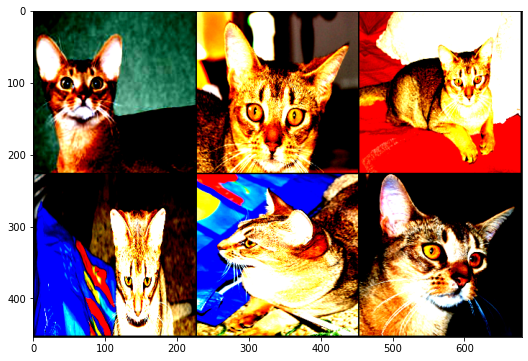

In [17]:
# displayig the data (looks this way because of normalization)
batch_tensor = next(iter(train_loader))[0][:6,...]
grid_img = torchvision.utils.make_grid(batch_tensor, nrow=3)

# grid_img.shape
plt.figure(figsize=(16,6))
plt.imshow(grid_img.permute(1, 2, 0));

In [18]:
model = models.resnet18(5).to(device) # good
# model = models.resnext50_32x4d(5).to(device) # 
# model = models.wide_resnet50_2(5).to(device) # 
# model = models.vgg(5).to(device) # good

# loss
criterion = nn.MSELoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.25, mode='min')

In [19]:
def train_model(n_epochs=1,
                model=model,
                train_loader=train_loader,
                valid_loader=valid_loader,
                criterion=criterion,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler):
    
    total_time = time.time()
    print(f'================')
    print(f'started training...')
    print(f'================')

    for epoch in range(n_epochs):
        
        model.train()

        t0 = time.time()

        correct_on_epoch = 0 # train acc
        total_num_images = 0 # train acc
        epoch_loss = 0
        
        for batch, (images, labels) in enumerate(train_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            total_num_images += labels.size(0) # train acc

            optimizer.zero_grad()
            outputs = model(images.float())
            
            preds = outputs[:,-1].round() # train acc
            
            loss = criterion(outputs.float(), labels.float())
            
            epoch_loss += loss

            correct_on_batch = (preds==labels[:,-1]).sum().item() # train acc
            
            correct_on_epoch += correct_on_batch # train acc

            loss.backward()
            optimizer.step()
            # print(f'batch: {batch+1}')
        
        # train acc/loss
        train_epoch_acc = round((correct_on_epoch/total_num_images), 4) # train acc
        train_avg_epoch_loss = round(float(epoch_loss/len(train_loader)), 4)
        # valid acc/loss
        valid_avg_epoch_loss, valid_epoch_accuracy, mean_iou = test_model(model, valid_loader)
        # valid iou
        
        
        # lr_scheduler.step()
        # for reduce on plateau LR
        lr_scheduler.step(valid_avg_epoch_loss)
        epoch_time = round(time.time() - t0)
        
        print(f'epoch: [{epoch+1}/{n_epochs}] | train loss: {train_avg_epoch_loss} | train acc: {train_epoch_acc} | valid loss: {valid_avg_epoch_loss} | valid acc: {valid_epoch_accuracy} | iou: {mean_iou} | time: {epoch_time//60:.0f}m {epoch_time%60:.0f}s')
    
    return model

In [20]:
def test_model(model, test_loader):
    model.eval()
    
    correct_on_epoch = 0
    total_num_images = 0
    epoch_loss = 0
    epoch_iou = []

    all_batch_acc = []
    
    with torch.no_grad():
        
        for batch, (images, labels) in enumerate(test_loader):
            
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            true_bb = labels[:,:-1]
                        
            total_num_images += labels.size(0)
            outputs = model(images)
            preds = outputs[:,-1].round()
            pred_bb = outputs[:,:-1]
            loss = criterion(outputs, labels)
            epoch_loss += loss
            # round both labels and pres just in case
            correct_on_epoch += (preds==labels[:,-1].round()).sum().item()
            # batch iou
            epoch_iou.append(iou(true_bb, pred_bb))

    test_epoch_accuracy = round((correct_on_epoch/total_num_images), 4)
    test_avg_epoch_loss = round(float(epoch_loss/len(test_loader)), 4)
    mean_iou = np.round(np.mean(epoch_iou), 4)
    
    return test_avg_epoch_loss, test_epoch_accuracy, mean_iou

In [21]:
def iou(true_bb, pred_bb):

    batch_iou = []

    for idx, (true, pred) in enumerate(zip(true_bb, pred_bb)):

        pred = torch.clip(pred, min=0.0, max=1.0).to('cpu')
        true = torch.clip(true, min=0.0, max=1.0).to('cpu')

        xmin_t, ymin_t, xmax_t, ymax_t = true
        xmin_p, ymin_p, xmax_p, ymax_p = pred

        xmin_intersect = np.maximum(xmin_t, xmin_p)
        ymin_intersect = np.maximum(ymin_t, ymin_p)
        xmax_intersect = np.minimum(xmax_t, xmax_p)
        ymax_intersect = np.minimum(ymax_t, ymax_p)

        if xmin_intersect < xmax_intersect and ymin_intersect < ymax_intersect:

            intersection_area = (xmax_intersect - xmin_intersect) * (ymax_intersect - ymin_intersect)
            union_area = (xmax_t-xmin_t)*(ymax_t-ymin_t)+(xmax_p-xmin_p)*(ymax_p-ymin_p)-intersection_area + 1e-6

            assert intersection_area > 0, 'intersection area cat be < 0'
            assert union_area > 0, 'union area cant be < 0'

            iou = intersection_area / union_area
            batch_iou.append(iou)

        else:
            batch_iou.append(0.0)

    return np.round(np.mean(batch_iou), 4)

# tests
# 1 in 2 vertical
bb_1 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_2 = torch.tensor([[0, 0, 0.5, 1], [0, 0, 0.5, 1]])
# 2 in 1 vertical
bb_3 = torch.tensor([[0, 0, 0.5, 1], [0, 0, 0.5, 1]])
bb_4 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
# 1 inside 2 horizontal
bb_5 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_6 = torch.tensor([[0, 0, 1, 0.5], [0, 0, 1, 0.5]])
# 2 inside 1 horizontal
bb_7 = torch.tensor([[0, 0, 1, 0.5], [0, 0, 1, 0.5]])
bb_8 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
# no itersection
bb_9 = torch.tensor([[0, 0, 0.5, 0.5], [0, 0, 0.5, 0.5]])
bb_10 = torch.tensor([[0.5, 0, 1, 0.5], [0.5, 0, 1, 0.5]])

# test
assert iou(bb_1, bb_2) == 0.5
assert iou(bb_3, bb_4) == 0.5
assert iou(bb_5, bb_6) == 0.5
assert iou(bb_7, bb_8) == 0.5
assert iou(bb_9, bb_10) == 0

In [22]:
# unfreeze all the params for training
def unfreeze(model=model):
    for param in model.parameters():
        param.requires_grad = True
    return model

In [23]:
# %%time

train_model(frozen)
unfreeze()
train_model(unfrozen)
print('')

started training...
epoch: [1/3] | train loss: 0.5476 | train acc: 0.159 | valid loss: 0.2093 | valid acc: 0.2526 | iou: 0.3001 | time: 17m 24s
epoch: [2/3] | train loss: 1.1104 | train acc: 0.1093 | valid loss: 0.3811 | valid acc: 0.0133 | iou: 0.4109 | time: 0m 23s
epoch: [3/3] | train loss: 1.0952 | train acc: 0.1024 | valid loss: 0.3444 | valid acc: 0.0133 | iou: 0.4085 | time: 0m 22s
started training...
epoch: [1/25] | train loss: 1.0587 | train acc: 0.1497 | valid loss: 5.9814 | valid acc: 0.0 | iou: 0.2696 | time: 0m 22s
epoch: [2/25] | train loss: 0.3085 | train acc: 0.352 | valid loss: 0.0527 | valid acc: 0.8227 | iou: 0.4664 | time: 0m 22s
epoch: [3/25] | train loss: 0.1209 | train acc: 0.5116 | valid loss: 0.0666 | valid acc: 0.6381 | iou: 0.4761 | time: 0m 22s
epoch: [4/25] | train loss: 0.1012 | train acc: 0.5298 | valid loss: 0.0425 | valid acc: 0.8877 | iou: 0.48 | time: 0m 22s
epoch: [5/25] | train loss: 0.0856 | train acc: 0.5593 | valid loss: 0.0391 | valid acc: 0.896

In [24]:
# lr=0.01, momentum=0.9, RandomSizedBBoxSafeCrop
# ReduceLROnPlateau(optimizer, patience=2, factor=0.5, mode='min')
#  SGD, resnet18
# epoch: [20/20] | train loss: 0.0238 | train acc: 0.9355 | valid loss: 0.0221 | valid acc: 0.9483 | iou: 0.586 | time: 0m 29s

In [25]:
# checkpoint = {'model': model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, MODEL_OUTPUT)

In [26]:
%%time
# testing with train data
_, train_acc, train_iou = test_model(model, train_loader)
print(f'train acc: {train_acc} | train iou: {train_iou}')

train acc: 0.9311 | train iou: 0.5806
CPU times: user 14.4 s, sys: 1.47 s, total: 15.9 s
Wall time: 17.5 s


In [27]:
%%time
# testing with test data
_, test_acc, test_iou = test_model(model, test_loader)
print(f'test acc: {test_acc} | test iou: {test_iou}')

test acc: 0.9217 | test iou: 0.5633
CPU times: user 5.45 s, sys: 683 ms, total: 6.13 s
Wall time: 4min 8s


In [28]:
%%time
# tta with test data
tta_crop = int(presize*0.9)
tta_model = tta.ClassificationTTAWrapper(model, tta.aliases.five_crop_transform(tta_crop, tta_crop))

tta_transforms = A.Compose([
    A.LongestMaxSize(presize),
    A.PadIfNeeded(presize, presize, border_mode=cv2.BORDER_CONSTANT, value=(0,0,0)),
    A.Normalize(),
    albumentations.pytorch.ToTensorV2()
])

tta_dataset = dataset(valid_df, transform=tta_transforms)
tta_loader = DataLoader(tta_dataset, batch_size=1, shuffle=False) # num_workers=0 on cpu

_, tta_acc, tta_iou = test_model(tta_model, tta_loader)

print(f'TTA acc: {tta_acc} | tta iou: {tta_iou}')

TTA acc: 0.8685 | tta iou: 0.3939
CPU times: user 11.5 s, sys: 257 ms, total: 11.7 s
Wall time: 12.3 s


In [29]:
total_time = time.time() - start
print(f'Total time: {total_time//60:.0f}m {total_time%60:.0f}s')

Total time: 33m 50s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


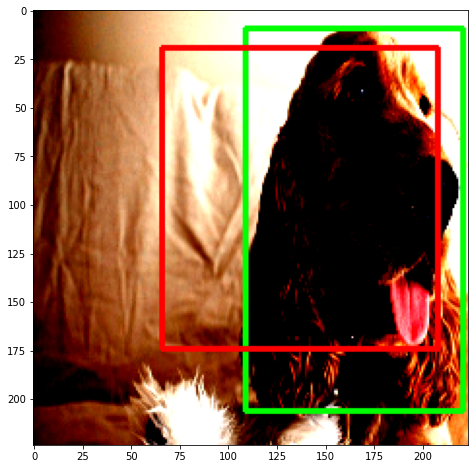

In [30]:
with torch.no_grad():
    # visualize predictions of the model
    # take a random picture from a dataset
    idx = np.random.randint(len(train_dataset))
    image, label = train_dataset[idx]
    # predict new bbox
    image = torch.unsqueeze(image, 0)
    model.to('cpu')
    outputs = model(image)
    outputs = outputs.flatten()
    # print(f'outputs shape: {outputs}')
    pred_bb = np.round(outputs[:-1], 4).tolist() # <---- pred bb
    # print(f'pred bb shape: {pred_bb}')
    pred_start = (int(pred_bb[0]*crop), int(pred_bb[1]*crop))
    pred_end = (int(pred_bb[2]*crop), int(pred_bb[3]*crop))
    pred_id = outputs[-1].long().item()
    # need to permute tensor for visualization
    image = torch.squeeze(image, 0)
    image = np.array(image.permute(1, 2, 0))
    # bbox = first 4 digits
    bbox = np.round(label[:-1], 4).tolist() # <---- true bb
    # class = last digit
    class_id = label[-1].long().item()
    # define 2 points for rectangle
    start_point = (int(bbox[0]*crop), int(bbox[1]*crop))
    end_point = (int(bbox[2]*crop), int(bbox[3]*crop))
    # define a color and thickness
    color = (0, 255, 0)
    color2 = (255, 0, 0)
    
    thickness = 2

    image = cv2.rectangle(image, start_point, end_point, color, thickness)
    image = cv2.rectangle(image, pred_start, pred_end, color2, thickness)

    # cv2.imshow('image', image)
    plt.figure(figsize=(8, 8))
    plt.imshow(np.array(image));